<p style="font-size:30px"> L_H & L_He in the F4 run: YProfiles vs RProfiles</p>


<p style="font-size:20px"> As Functions</p>


In [1]:
import time
import nugridpy.utils as utils
from ppmpy.ppm import *
import numpy as np
import matplotlib.pyplot as pl
%matplotlib nbagg
import nugridpy.astronomy as ast
import sys
sys.path.insert(0, '/data/ppm_rpod2/lib/lcse')
import rprofile as rprof
%load_ext autoreload
%autoreload 2

In [2]:
def get_luminosity(path, airmu = 1.39165, cldmu = 0.725,\
    fkair = 0.203606102635, fkcld = 0.885906040268, AtomicNoair = 6.65742024965,\
    AtomicNocld = 1.34228187919, get_t = False):
    
    '''
    
    Takes a directory and returns luminosity and time vector with entry
    corresponding to each file in the dump
    
    !Can take both rprofile and yprofile filepaths
    
    Parameters
    ----------
    path : string
        Filepath for the dumps, rprofile or yprofile dumps.

    Returns
    -------
    t : 1*ndumps array
        time vector [t/min]
    L_H : 1*ndumps array
        luminosity vector [L/Lsun]
    
    '''
    
    yprof = yprofile(path)
    
    try:
        dumps = np.arange(min(yprof.ndumpDict.keys())+1,\
                          #min(yprof.ndumpDict.keys())+100,1)
                          max(yprof.ndumpDict.keys()) + 1, 1)
        is_yprofile = True
    except:
        
        rp_set = rprof.rprofile_set(path)
        dumps = range(rp_set.dumps[0],\
                      #rp_set.dumps[0]+100,1)
                      rp_set.dumps[-1]+1,1)
        r_rp = rp_set.get_dump(dumps[0]).get('y')
        dV_rp = 4.*np.pi*r_rp**2*cdiff(r_rp)
        is_yprofile = False
        yprof = yprofile(path.replace('RProfiles','YProfiles'))

    patience0 = 5
    patience = 10

    nd = len(dumps)
    t = np.zeros(nd)
        
    L_H = np.zeros(nd)
    
    t00 = time.time()
    t0 = t00
    k = 0
    for i in range(nd):
        if is_yprofile:
            if get_t:
                t[i] = yprof.get('t', fname = dumps[i], resolution = 'l')[-1]

            L_H[i] = yprof.get('L_C12pg', fname = dumps[i], resolution = 'l', airmu = airmu, \
                                  cldmu = cldmu, fkair = fkair, fkcld = fkcld, AtomicNoair = AtomicNoair, \
                                  AtomicNocld = AtomicNocld, corr_fact = 1.5)
        
        else:
            
            rp = rp_set.get_dump(dumps[i])
            enuc_rp = rp.get_table('enuc')
            if get_t:
                t[i] = rp.get('time')  
            # It looks like we do not need to make a correction for the heating bug here. Strange!!!
            L_H[i] = np.sum(enuc_rp[0, :, 0]*dV_rp)

        t_now = time.time()
        if (t_now - t0 >= patience) or \
           ((t_now - t00 < patience) and (t_now - t00 >= patience0) and (k == 0)):
            time_per_dump = (t_now - t00)/float(i + 1)
            time_remaining = (nd - i - 1)*time_per_dump
            print 'Processing will be done in {:.0f} s.'.format(time_remaining)
            t0 = t_now
            k += 1
    if get_t:        
        return t, L_H
    else:
        return L_H

In [3]:
def cdiff(x):
            dx = 0.5*(np.roll(x, -1) - np.roll(x, +1))
            dx[0] = dx[1]
            dx[-1] = dx[-2]

            return dx

In [7]:
def plot_luminosity( L, t, L_He = 2.25*2.98384E-03, ifig = 10):
    
    '''
    
    Plots luminosity vectors against the same time vector
        
    Parameters
    ----------
    L : array
             Luminosity vectors, N x M where N is number of vectors to plot
             and M is number of entries
    t : vector size(L(:,1))
             time vector to be plotted on the x-axis
    '''
    cb = utils.colourblind

    pl.close(ifig); pl.figure(ifig)
    for k in size(L[1,:]):
        pl.semilogy(t/60., (1e43/ast.lsun_erg_s)*L[:,k], color = cb(5), \
                     lw = 2., zorder = 2, label = r'L$_\mathrm{H,yp}$')
    pl.axhline((1e43/ast.lsun_erg_s)*L_He, ls = '--', color = cb(4), \
                zorder = 1, label = r'L$_\mathrm{He}$')
    pl.xlabel('t / min')
    pl.ylabel(r'L / L$_\odot$')
    pl.legend(loc = 0)
    pl.tight_layout()

In [8]:
L_H_yp = get_luminosity('/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F4')

Reading attributes from file  YProfile-01-1959.bobaaa
Analyzing headers ...
There are 1960 YProfile files in the /data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F4 directory.
Ndump values range from 0 to 1959
Time values range from 86.5493 to 162264.0
Processing will be done in 1147 s.
Processing will be done in 1116 s.
Processing will be done in 1116 s.
Processing will be done in 1129 s.
Processing will be done in 1128 s.
Processing will be done in 1126 s.
Processing will be done in 1125 s.
Processing will be done in 1131 s.
Processing will be done in 1127 s.
Processing will be done in 1125 s.
Processing will be done in 1121 s.
Processing will be done in 1112 s.
Processing will be done in 1105 s.
Processing will be done in 1097 s.
Processing will be done in 1093 s.
Processing will be done in 1087 s.
Processing will be done in 1082 s.
Processing will be done in 1076 s.
Processing will be done in 1071 s.
Processing will be done in 1066 s.
Processing will be done in 1063 s.
Processing will be

KeyboardInterrupt: 

In [40]:
t, L_H_rp = get_luminosity('/data/ppm_rpod2/RProfiles/AGBTP_M2.0Z1.e-5/F4', True)

Error: no YProfile named files exist in Directory
Now returning None
Reading attributes from file  YProfile-01-1959.bobaaa
Analyzing headers ...
There are 1960 YProfile files in the /data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F4 directory.
Ndump values range from 0 to 1959
Time values range from 86.5493 to 162264.0
Processing will be done in 2 s.


<IPython.core.display.Javascript object>


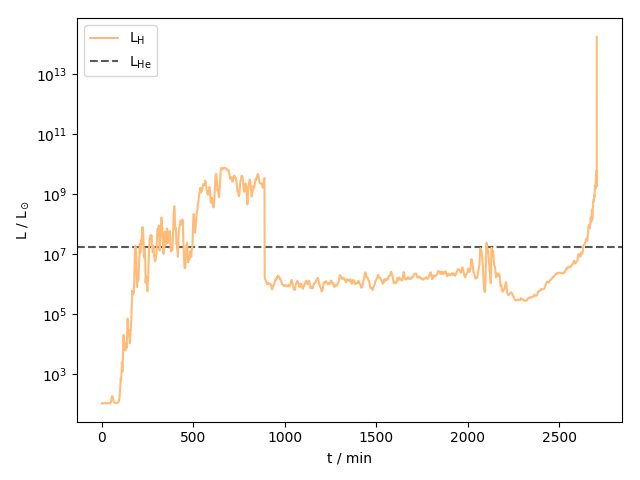

<IPython.core.display.Javascript object>


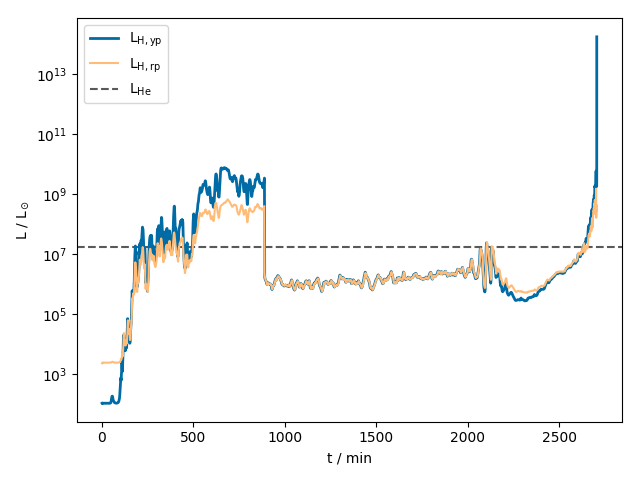

In [43]:
plot_luminosity(L_H_yp,L_H_rp,t)

<p style="font-size:20px"> Luminosities As Script</p>

In [ ]:

yprof = yprofile('/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F4')
rp_set = rprofile.rprofile_set('/data/ppm_rpod2/RProfiles/AGBTP_M2.0Z1.e-5/F4') 

CN = 96.480733
Q = 1.944
RR = 8.3144598

airmu = 1.39165
cldmu = 0.725
fkair = 0.203606102635
fkcld = 0.885906040268
AtomicNoair = 6.65742024965
AtomicNocld = 1.34228187919

atomicnocldinv = 1./AtomicNocld
atomicnoairinv = 1./AtomicNoair

cb = utils.colourblind

patience0 = 5
patience = 10

In [ ]:
dumps = range(1, 1959, 1)
nd = len(dumps)
t = np.zeros(nd)
L_H_yp = np.zeros(nd)
L_H_rp = np.zeros(nd)
L_He = 2.25*2.98384E-03

r_rp = rp_set.get_dump(dumps[0]).get('y')
dV_rp = 4.*np.pi*r_rp**2*cdiff(r_rp)
t00 = time.time()
t0 = t00
k = 0
for i in range(nd):
    t[i] = yprof.get('t', fname = dumps[i], resolution = 'l')[-1]
    
    L_H_yp[i] = yprof.get('L_C12pg', fname = dumps[i], resolution = 'l', airmu = airmu, \
                          cldmu = cldmu, fkair = fkair, fkcld = fkcld, AtomicNoair = AtomicNoair, \
                          AtomicNocld = AtomicNocld, corr_fact = 1.5)
    
    rp = rp_set.get_dump(dumps[i])
    enuc_rp = rp.get_table('enuc')
    
    # It looks like we do not need to make a correction for the heating bug here. Strange!!!
    L_H_rp[i] = np.sum(enuc_rp[0, :, 0]*dV_rp)
    
    t_now = time.time()
    if (t_now - t0 >= patience) or \
       ((t_now - t00 < patience) and (t_now - t00 >= patience0) and (k == 0)):
        time_per_dump = (t_now - t00)/float(i + 1)
        time_remaining = (nd - i - 1)*time_per_dump
        print 'Processing will be done in {:.0f} s.'.format(time_remaining)
        t0 = t_now
        k += 1

In [ ]:
ifig = 1; pl.close(ifig); pl.figure(ifig)
pl.semilogy(t/60., (1e43/ast.lsun_erg_s)*L_H_yp, color = cb(6), \
             zorder = 2, label = r'L$_\mathrm{H}$')
pl.axhline((1e43/ast.lsun_erg_s)*L_He, ls = '--', color = cb(4), \
            zorder = 1, label = r'L$_\mathrm{He}$')
pl.xlabel('t / min')
pl.ylabel(r'L / L$_\odot$')
pl.xlim((0., 2.8e3))
pl.ylim((1e5, 1e10))
pl.legend(loc = 0)
pl.tight_layout()

ifig = 2; pl.close(ifig); pl.figure(ifig)
pl.semilogy(t/60., (1e43/ast.lsun_erg_s)*L_H_yp, color = cb(5), \
             lw = 2., zorder = 2, label = r'L$_\mathrm{H,yp}$')
pl.semilogy(t/60., (1e43/ast.lsun_erg_s)*L_H_rp, color = cb(6), \
             zorder = 4, label = r'L$_\mathrm{H,rp}$')
pl.axhline((1e43/ast.lsun_erg_s)*L_He, ls = '--', color = cb(4), \
            zorder = 1, label = r'L$_\mathrm{He}$')
pl.xlabel('t / min')
pl.ylabel(r'L / L$_\odot$')
pl.xlim((0., 2.8e3))
pl.ylim((1e5, 1e10))
pl.legend(loc = 0)
pl.tight_layout()

<IPython.core.display.Javascript object>


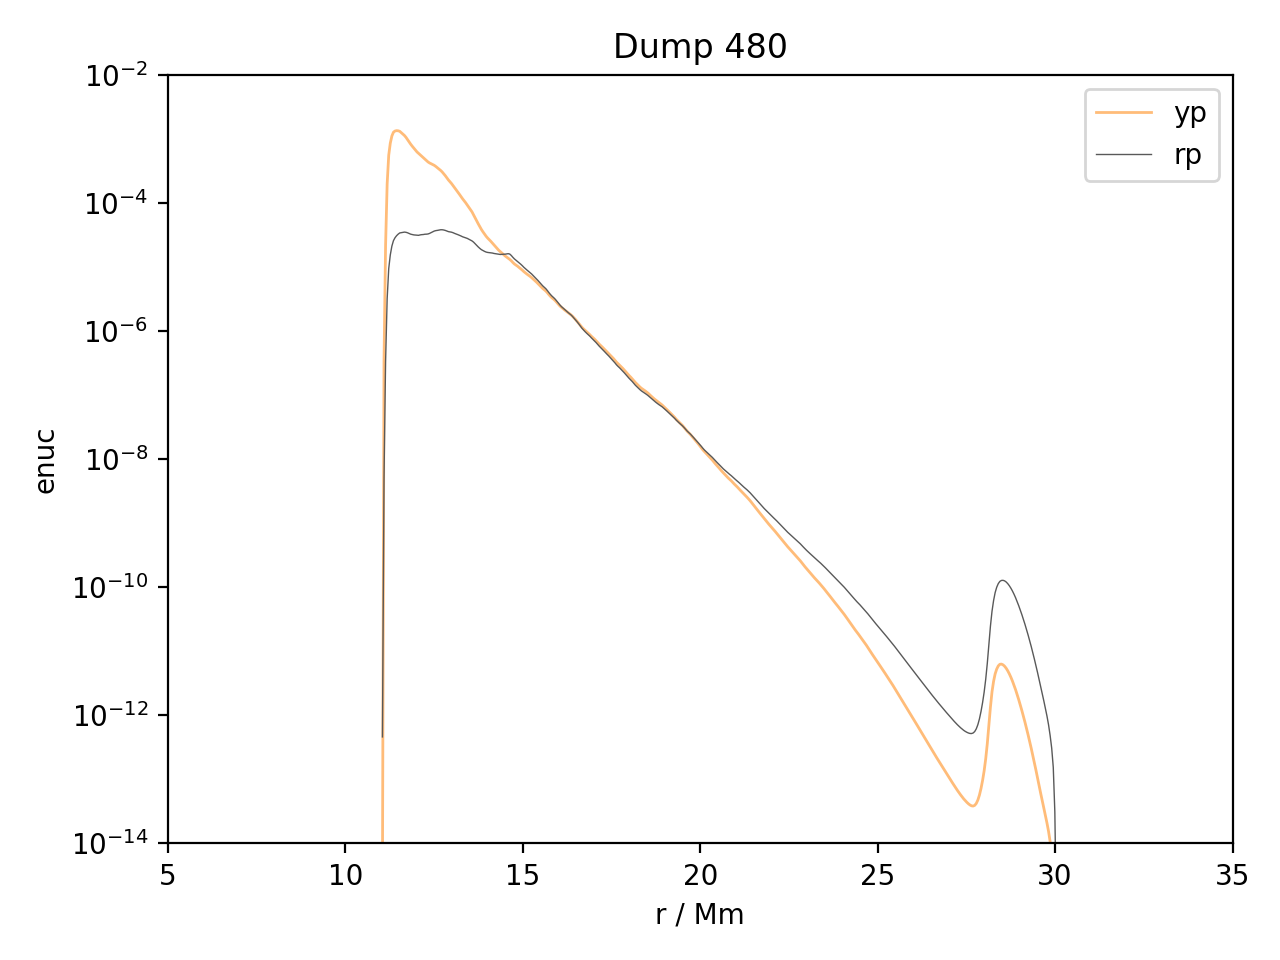

<IPython.core.display.Javascript object>


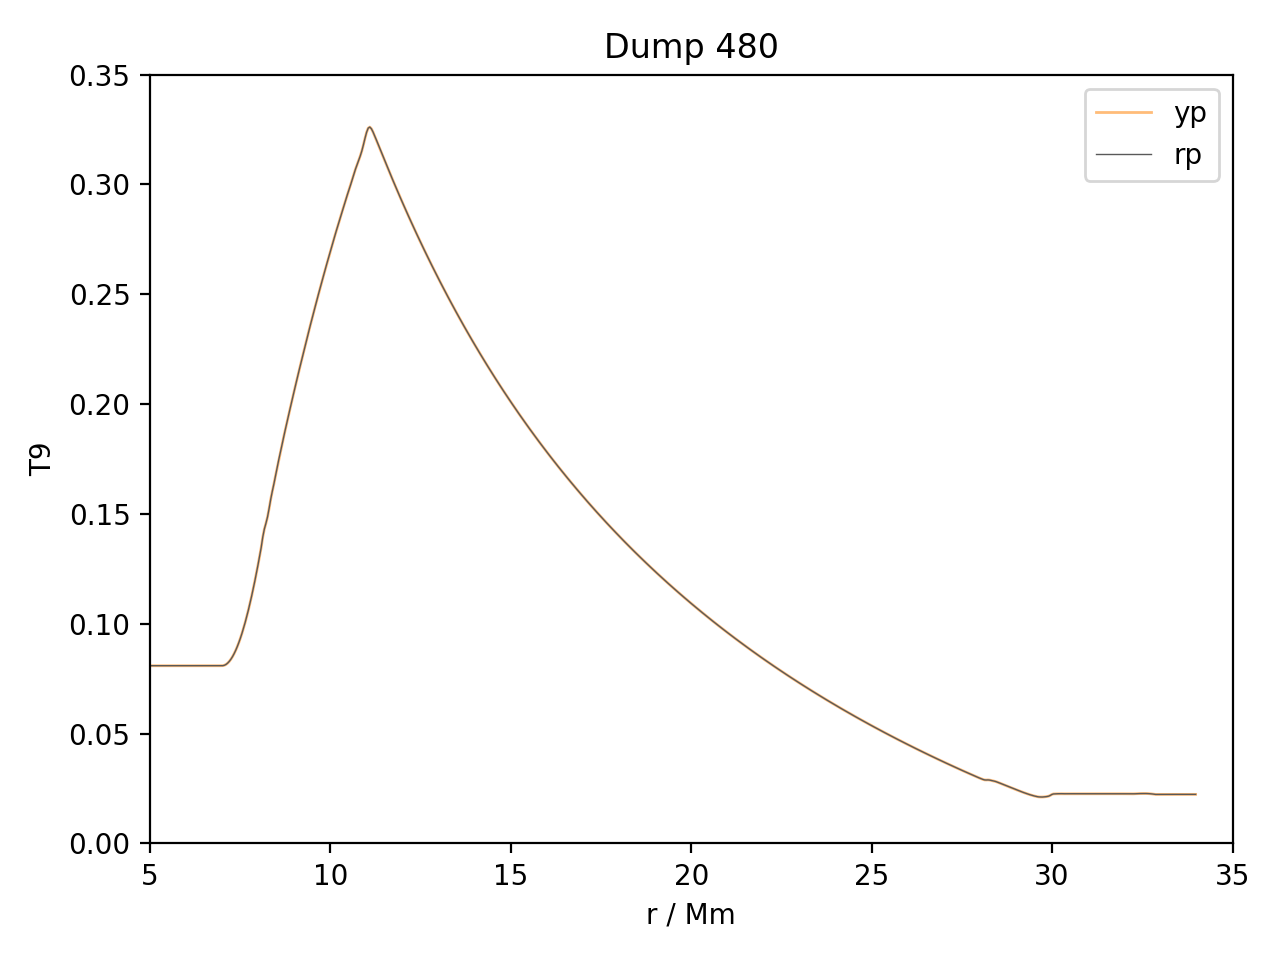

In [12]:
dmp = 480

r_yp = yprof.get('Y', fname = dmp, resolution = 'l')
enuc_yp = yprof.get('enuc_C12pg', fname = dmp, numtype = 'ndump', resolution = 'l', airmu = airmu, \
           cldmu = cldmu, fkair = fkair, fkcld = fkcld, AtomicNoair = AtomicNoair, \
           AtomicNocld = AtomicNocld, corr_fact = 1.5)
T9_yp = yprof.get('T9', fname = dmp, resolution = 'l', cldmu = cldmu, airmu = airmu)

rp = rp_set.get_dump(dmp + 1)
r_rp = rp.get('y')
enuc_rp = rp.get_table('enuc')[0, :, 0]
fv_rp = rp.get_table('fv')[0, :, 0]
rho_rp = rp.get_table('rho')[0, :, 0]
p_rp = rp.get_table('p')[0, :, 0]
mu_rp = cldmu*fv_rp + airmu*(1. - fv_rp)
T9_rp = p_rp*mu_rp/(RR*rho_rp)

ifig = 3; pl.close(ifig); pl.figure(ifig)
pl.semilogy(r_yp, enuc_yp, color = cb(6), lw = 1.0, label = 'yp')
pl.semilogy(r_rp, enuc_rp, color = cb(4), lw = 0.5, label = 'rp')
pl.xlim((5., 35.))
pl.ylim((1e-14, 1e-2))
pl.xlabel('r / Mm')
pl.ylabel('enuc')
pl.title('Dump {:d}'.format(dmp))
pl.legend(loc = 0)
pl.tight_layout()

ifig = 4; pl.close(ifig); pl.figure(ifig)
pl.plot(r_yp, T9_yp, color = cb(6), lw = 1.0, label = 'yp')
pl.plot(r_rp, T9_rp, color = cb(4), lw = 0.5, label = 'rp')
pl.xlim((5., 35.))
pl.ylim((0.0, 0.35))
pl.xlabel('r / Mm')
pl.ylabel('T9')
pl.title('Dump {:d}'.format(dmp))
pl.legend(loc = 0)
pl.tight_layout()

In [ ]:
dmp = 480

r_yp = yprof.get('Y', fname = dmp, resolution = 'l')
enuc_yp = yprof.get('enuc_C12pg', fname = dmp, numtype = 'ndump', resolution = 'l', airmu = airmu, \
           cldmu = cldmu, fkair = fkair, fkcld = fkcld, AtomicNoair = AtomicNoair, \
           AtomicNocld = AtomicNocld, corr_fact = 1.5)
T9_yp = yprof.get('T9', fname = dmp, resolution = 'l', cldmu = cldmu, airmu = airmu)

rp = rp_set.get_dump(dmp + 1)
r_rp = rp.get('y')
enuc_rp = rp.get_table('enuc')[0, :, 0]
fv_rp = rp.get_table('fv')[0, :, 0]
rho_rp = rp.get_table('rho')[0, :, 0]
p_rp = rp.get_table('p')[0, :, 0]
mu_rp = cldmu*fv_rp + airmu*(1. - fv_rp)
T9_rp = p_rp*mu_rp/(RR*rho_rp)

ifig = 3; pl.close(ifig); pl.figure(ifig)
pl.semilogy(r_yp, enuc_yp, color = cb(6), lw = 1.0, label = 'yp')
pl.semilogy(r_rp, enuc_rp, color = cb(4), lw = 0.5, label = 'rp')
pl.xlim((5., 35.))
pl.ylim((1e-14, 1e-2))
pl.xlabel('r / Mm')
pl.ylabel('enuc')
pl.title('Dump {:d}'.format(dmp))
pl.legend(loc = 0)
pl.tight_layout()

ifig = 4; pl.close(ifig); pl.figure(ifig)
pl.plot(r_yp, T9_yp, color = cb(6), lw = 1.0, label = 'yp')
pl.plot(r_rp, T9_rp, color = cb(4), lw = 0.5, label = 'rp')
pl.xlim((5., 35.))
pl.ylim((0.0, 0.35))
pl.xlabel('r / Mm')
pl.ylabel('T9')
pl.title('Dump {:d}'.format(dmp))
pl.legend(loc = 0)
pl.tight_layout()

<IPython.core.display.Javascript object>


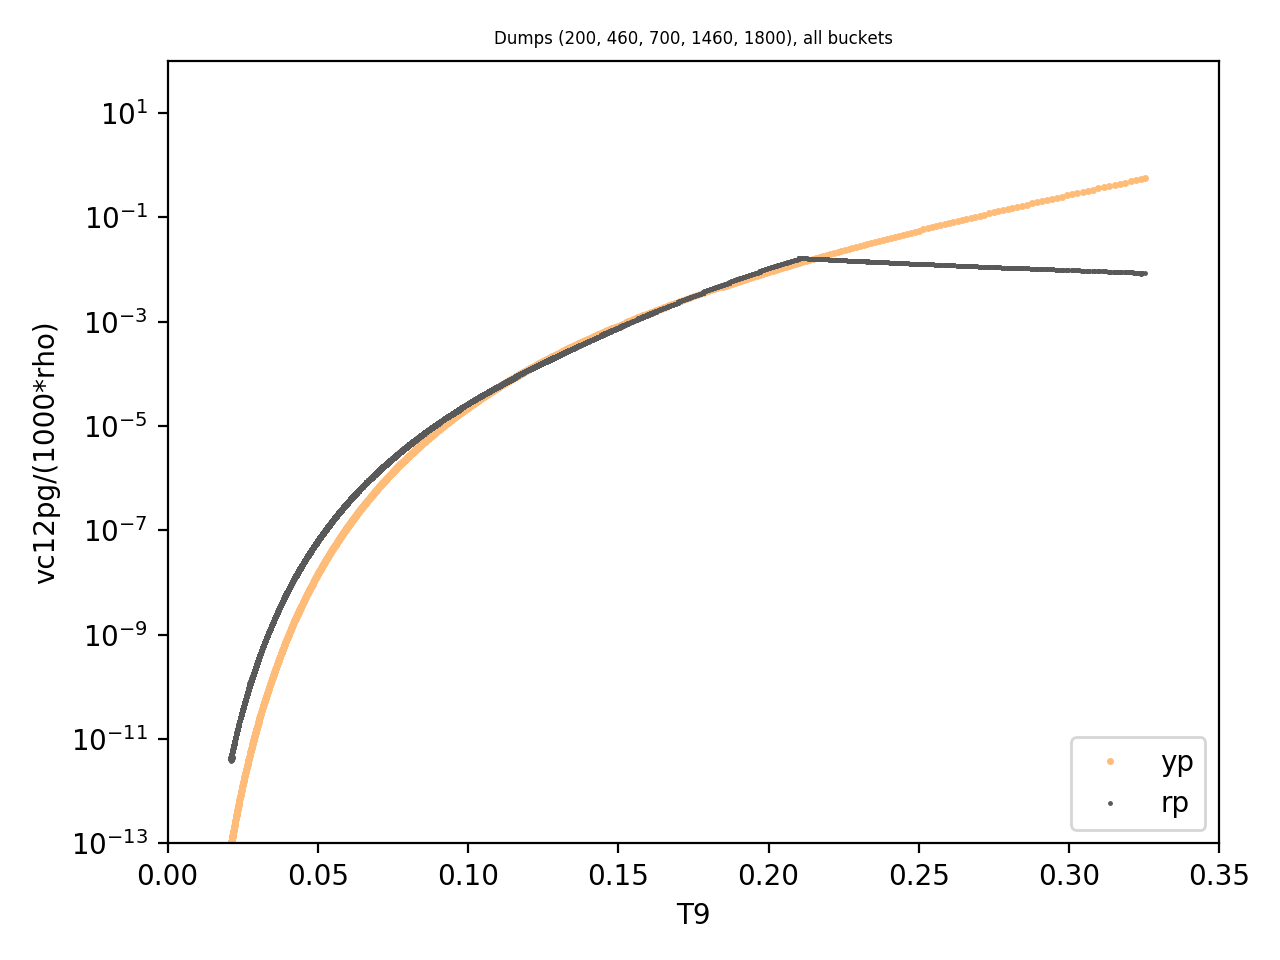

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in divide


In [13]:
dmps = (200, 460, 700, 1460, 1800)

ifig = 5; pl.close(ifig); pl.figure(ifig)
for i in range(len(dmps)):
    dmp = dmps[i]

    fv_yp = yprof.get('FV H+He', fname = dmp, resolution = 'l')
    rho_yp = yprof.get('Rho', fname = dmp, resolution = 'l')
    rhocld_yp = yprof.get('Rho H+He', fname = dmp, resolution = 'l')
    rhoair_yp = yprof.get('RHOconv', fname = dmp, resolution = 'l')
    T9_yp = yprof.get('T9', fname = dmp, resolution = 'l', cldmu = cldmu, airmu = airmu)
    enuc_yp = yprof.get('enuc_C12pg', fname = dmp, numtype = 'ndump', resolution = 'l', airmu = airmu, \
               cldmu = cldmu, fkair = fkair, fkcld = fkcld, AtomicNoair = AtomicNoair, \
               AtomicNocld = AtomicNocld, corr_fact = 1.0)

    v_yp = 1./rho_yp
    Y1_yp =  rhocld_yp * fv_yp * v_yp * atomicnocldinv
    Y2_yp =  rhoair_yp * (1. - fv_yp) * v_yp * atomicnoairinv

    DY_yp = enuc_yp/(rho_yp*CN*Q)

    vc12pg_yp = DY_yp/(fkcld*fkair*Y1_yp*Y2_yp)
    vc12pgbyrho_yp = vc12pg_yp/(1000.*rho_yp)
    
    lbl = ''
    if i == 0:
        lbl = 'yp'
    idx_yp = where((fv_yp > 1e-8) & (fv_yp < 0.999))
    pl.semilogy(T9_yp[idx_yp], vc12pgbyrho_yp[idx_yp], ls = '', color = cb(6), \
                 marker = '.', markersize = 3., label = lbl)

    rp = rp_set.get_dump(dmp + 1)
    for bucket in range(0, 81, 1):
        fv_rp = rp.get_table('fv')[0, :, bucket]
        rho_rp = rp.get_table('rho')[0, :, bucket]
        rhocld_rp = rp.get_table('rhospike')[0, :, bucket]
        rhoair_rp = rp.get_table('rhobubble')[0, :, bucket]
        p_rp = rp.get_table('p')[0, :, bucket]
        mu_rp = cldmu*fv_rp + airmu*(1. - fv_rp)
        T9_rp = p_rp*mu_rp/(RR*rho_rp)
        enuc_rp = rp.get_table('enuc')[0, :, bucket]

        v_rp = 1./rho_rp
        Y1_rp =  rhocld_rp * fv_rp * v_rp * atomicnocldinv
        Y2_rp =  rhoair_rp * (1. - fv_rp) * v_rp * atomicnoairinv

        # Plots above suggest that RProfile data contain the factor of 1.5
        # that corrects for the heating bug.
        enuc_rp /= 1.5
        
        DY_rp = enuc_rp/(rho_rp*CN*Q)

        vc12pg_rp = DY_rp/(fkcld*fkair*Y1_rp*Y2_rp)
        vc12pgbyrho_rp = vc12pg_rp/(1000.*rho_rp)

        lbl = ''
        if (i == 0) and (bucket == 0):
            lbl = 'rp'
        idx_rp = where((fv_rp > 1e-8) & (fv_rp < 0.999))
        pl.semilogy(T9_rp[idx_rp], vc12pgbyrho_rp[idx_rp], ls = '', color = cb(4),
                     marker = '.', markersize = 1.5, label = lbl)
pl.xlabel('T9')
pl.ylabel('vc12pg/(1000*rho)')
pl.xlim((0., 0.35))
pl.ylim((1e-13, 1e2))
pl.title('Dumps ' + str(dmps) + ', all buckets', fontsize = 6)
pl.legend(loc = 4)
pl.tight_layout()